In [4]:
import os
import pathlib
import tqdm
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pathlib

import hashlib

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
from dataclasses import make_dataclass


%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_1826923/387537016.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [5]:
#%autoreload
import decode
import decode.utils

In [16]:
n_frames = 10000

# emitter specs
em_photon_range = (6000, 6001)  # photon_range (i.e. all emitters same)
#em_extent = ((-0.5, 63.5), (-0.5, 63.5), (-750., 750.)) 
#em_extent = ((5.5, 56.5), (5.5, 56.5), (-750., 750.))  # x y z
#em_extent = ([31.625, 32.375], (19.5, 43.5), 0.0)
em_extent = ([32, 32.625], (19.5, 43.5), (-500, 500))
#em_extent = ([31.5, 32.5], (19.5, 43.5), 0.0)
#em_extent = ((5.5, 56.5), (5.5, 56.5), (-500., 500.))

# psf
#calib_file = '/home/GaoQF/Downloads_original/01_fig2a_e_sim_density/Fit/CRLB_SNR/calib_3dcal.mat'
#calib_file = '/home/GaoQF/Downloads_original/experimental_data_workflow/spline_calibration_3dcal.mat'
calib_file = '/home/GaoQF/Downloads_original/experimental_data_workflow/spline_calibration_3dcal.mat'#'/home/GaoQF/Downloads_original/experimental_data_workflow/3_1_MMStack_Pos0.ome_reversed_3dcal_rev.mat'
psf_extent = ((-0.5, 63.5), (-0.5, 63.5))
img_size = (64, 64)

# bg and noise
bg_uniform = 50 #200

In [17]:
#structure = decode.simulation.FixedYPointsCylinderStructure(*em_extent)
#structure = decode.simulation.RandomStructure(*em_extent)
structure = decode.simulation.FixedXPointsStructure(*em_extent)
em_gen = decode.simulation.emitter_generator.EmitterSamplerFrameIndependent(structure=structure, photon_range=em_photon_range, em_avg=0., xy_unit='px', px_size=(160., 160.))

psf = decode.utils.calibration_io.SMAPSplineCoefficient(calib_file).init_spline(xextent=psf_extent[0], yextent=psf_extent[1], img_shape=img_size)
bg = decode.simulation.background.UniformBackground(bg_uniform=bg_uniform)
noise = decode.simulation.camera.PerfectCamera(device='cuda:7')

simulator = decode.simulation.Simulation(psf=psf, em_sampler=None, em_sampler_unfocused=None, background=bg, noise=noise, frame_range=(0, n_frames-1))

In [18]:
em = em_gen.sample_n(n_frames)
em.frame_ix = torch.arange(n_frames).long()  # one emitter per frame
#em.frame_ix = torch.arange(n_frames).repeat_interleave(10).long()
em.bg[:] = bg_uniform

print(em)

EmitterSet
::num emitters: 10000
::xy unit: px
::px size: tensor([160., 160.])
::frame range: 0 - 9999
::spanned volume: [  32.         19.500828 -499.89795 ] - [ 32.625     43.498814 499.83948 ]


In [6]:
em= decode.EmitterSet.load('/data1/ALLData/GaoQF/STORM/data/Fig2_simudata/simu_around/model_output_emitter_5.pt')
print(em)

EmitterSet
::num emitters: 100000
::xy unit: px
::px size: tensor([160., 160.])
::frame range: 0 - 9999
::spanned volume: [   5.5014925    5.5001397 -499.98343  ] - [ 56.499897  56.499104 499.99847 ]


In [ ]:
em_un_extent = ((9.5, 55.5), (9.5, 55.5), ((-1000, -500), (500, 1000)))
#em_un_photon_range = (4000, 6001)
intensity_mu_sig = (4000, 500)
structure_un = decode.simulation.RandomStructure_unfocused_around(*em_un_extent)
em_un_gen = decode.simulation.emitter_generator.EmitterSamplerBlinking_unfocused(structure=structure_un, intensity_mu_sig=intensity_mu_sig, lifetime=1, frame_range=(0, n_frames-1), xy_unit='px', px_size=(160., 160.), density=5)

In [20]:
em_un = em_un_gen.sample(em.xyz, em.frame_ix)
print(em_un)

EmitterSet
::num emitters: 20000
::xy unit: px
::px size: tensor([160., 160.])
::frame range: 0 - 9999
::spanned volume: [  29.000383   16.584364 -999.9889  ] - [ 35.624798  46.377502 999.996   ]


In [21]:
frames_em, frames, bg_frames = simulator.forward(em, em_un)
frames_em, frames, bg_frames = frames_em.cpu(), frames.cpu(), bg_frames.cpu()


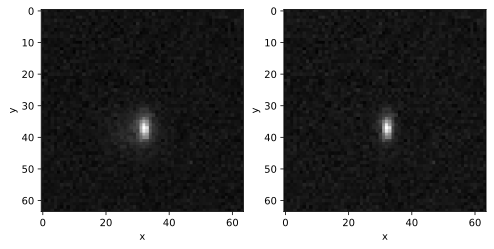

In [25]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))

ix = 6666

plt.subplot(121)
decode.plot.PlotFrameCoord(frame=frames[ix]).plot()

plt.subplot(122)
decode.plot.PlotFrameCoord(frame=frames_em[ix]).plot()

In [1]:
#os.chdir('/data1/ALLData/GaoQF/STORM/data/Fig2_simudata/simu_around')
os.chdir('/data1/ALLData/GaoQF/STORM/data/Fig2_simudata/simu_160nm/nk_beads')

NameError: name 'os' is not defined

In [14]:
file_frames = '100nmline_frames_1.pt'#'cylinder_frames_120nm_num1_5_smally.pt'
#file_em_csv = 'em_as_3d_lsnr.csv'
file_em_pl = '100nmline_emitter_1.pt'#'cylinder_emitter_120nm_num1_5_smally.pt'

#file_frames_em = 'model_output_frames_em_6.pt'
# save
#torch.save(frames, file_frames)
#torch.save(frames_em, '15_20_frames_em.pt')
torch.save(frames, file_frames)
#torch.save(frames_em, file_frames_em)
#decode.utils.emitter_io.save_csv(file_em_csv, em.to_dict())
em.save(file_em_pl)